In [1]:
'''

Objective: Build a Python tool to calculate and analyze VaR, CVaR, and other risk measures for a portfolio of financial assets.

Steps:

1.Download historical price data (e.g., via Yahoo Finance API or Alpha Vantage).
2.Calculate portfolio returns and volatility.
3.Compute VaR using:
  -Historical Simulation
  -Variance-Covariance (Parametric)
  -Monte Carlo Simulation
4.Compute CVaR (Expected Shortfall).
5.Visualize the risk metrics with histograms, distribution curves, and portfolio risk heatmaps.


'''

'\n\nObjective: Build a Python tool to calculate and analyze VaR, CVaR, and other risk measures for a portfolio of financial assets.\n\nSteps:\n\n1.Download historical price data (e.g., via Yahoo Finance API or Alpha Vantage).\n2.Calculate portfolio returns and volatility.\n3.Compute VaR using:\n  -Historical Simulation\n  -Variance-Covariance (Parametric)\n  -Monte Carlo Simulation\n4.Compute CVaR (Expected Shortfall).\n5.Visualize the risk metrics with histograms, distribution curves, and portfolio risk heatmaps.\n\n\n'

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd

In [12]:
# User input

#Portfolio configuration
num_assets = int(input("Enter the number of assets in the portfolio (min: 2, max: 10): "))

# Get ticker symbols
tickers = []
for i in range(num_assets):
    ticker = input(f"Enter ticker symbol for Asset {i+1} (e.g., AAPL, MSFT): ")
    tickers.append(ticker)

# Fetch historical data
start_date = input("Enter start date for historical data (YYYY-MM-DD): ")
end_date = input("Enter end date for historical data (YYYY-MM-DD): ")

# User input: Weights
print("\nEnter portfolio weights for each asset (should sum to 1.0):")
weights = []
for ticker in tickers:
    weight = float(input(f"Weight for {ticker} (as a fraction, e.g., 0.25 for 25%): "))
    weights.append(weight)
weights = np.array(weights)

# Input: Initial investment
initial_investment = float(input("\nEnter initial investment amount ($): "))

# Input: Simulation settings
num_simulations = int(input("Enter the number of simulations (e.g., 10000): "))
confidence_level = float(input("Enter confidence level for VaR & CVaR (e.g., 0.95): "))

# Stress Testing
stressed_asset_index = int(input(f"Choose asset to stress (1-{num_assets}): ")) - 1
stress_shock = float(input(f"Enter shock for {tickers[stressed_asset_index]} (%) [-50 to 50]: "))

Enter the number of assets in the portfolio (min: 2, max: 10): 3
Enter ticker symbol for Asset 1 (e.g., AAPL, MSFT): AAPL
Enter ticker symbol for Asset 2 (e.g., AAPL, MSFT): MSFT
Enter ticker symbol for Asset 3 (e.g., AAPL, MSFT): GOOG
Enter start date for historical data (YYYY-MM-DD): 2023-12-02
Enter end date for historical data (YYYY-MM-DD): 2024-11-02

Enter portfolio weights for each asset (should sum to 1.0):
Weight for AAPL (as a fraction, e.g., 0.25 for 25%): 0.25
Weight for MSFT (as a fraction, e.g., 0.25 for 25%): 0.25
Weight for GOOG (as a fraction, e.g., 0.25 for 25%): 0.5

Enter initial investment amount ($): 1000
Enter the number of simulations (e.g., 10000): 10000
Enter confidence level for VaR & CVaR (e.g., 0.95): 0.95
Choose asset to stress (1-3): 2
Enter shock for MSFT (%) [-50 to 50]: -10


In [13]:
#Download data
def get_portfolio_data(tickers, start_date, end_date):
    # Fetch adjusted closing prices
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    if isinstance(data, pd.Series):
        data = data.to_frame()

    # Calculate daily returns
    daily_returns = data.pct_change().dropna()

    # Compute expected returns and covariance matrix
    expected_returns = daily_returns.mean() * 252  # Annualized mean returns
    cov_matrix = daily_returns.cov() * 252  # Annualized covariance matrix

    return expected_returns, cov_matrix

# Function to simulate portfolio returns
def simulate_portfolio_returns(mean_returns, cov_matrix, weights, num_simulations):
    simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)
    portfolio_returns = simulated_returns.dot(weights)
    return portfolio_returns

# Calculate VaR and CVaR
def calculate_var_cvar(portfolio_returns, confidence_level):
    sorted_returns = np.sort(portfolio_returns)
    var_index = int((1 - confidence_level) * len(sorted_returns))
    var = sorted_returns[var_index]
    cvar = sorted_returns[:var_index].mean()
    return var, cvar





In [14]:
expected_returns, cov_matrix = get_portfolio_data(tickers, start_date, end_date)
stressed_returns = expected_returns.copy()
stressed_returns[stressed_asset_index] *= (1 + stress_shock / 100)
original_portfolio_returns = simulate_portfolio_returns(expected_returns, cov_matrix, weights, num_simulations)
stressed_portfolio_returns = simulate_portfolio_returns(stressed_returns, cov_matrix, weights, num_simulations)
original_var, original_cvar = calculate_var_cvar(original_portfolio_returns, confidence_level)
stressed_var, stressed_cvar = calculate_var_cvar(stressed_portfolio_returns, confidence_level)


[*********************100%***********************]  3 of 3 completed
<ipython-input-14-f0a1736fa9b3>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stressed_returns[stressed_asset_index] *= (1 + stress_shock / 100)
<ipython-input-14-f0a1736fa9b3>:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  stressed_returns[stressed_asset_index] *= (1 + stress_shock / 100)



Risk Metrics:
Original Portfolio - VaR: $-92.98, CVaR: $-167.03
Stressed Portfolio - VaR: $-98.93, CVaR: $-179.21


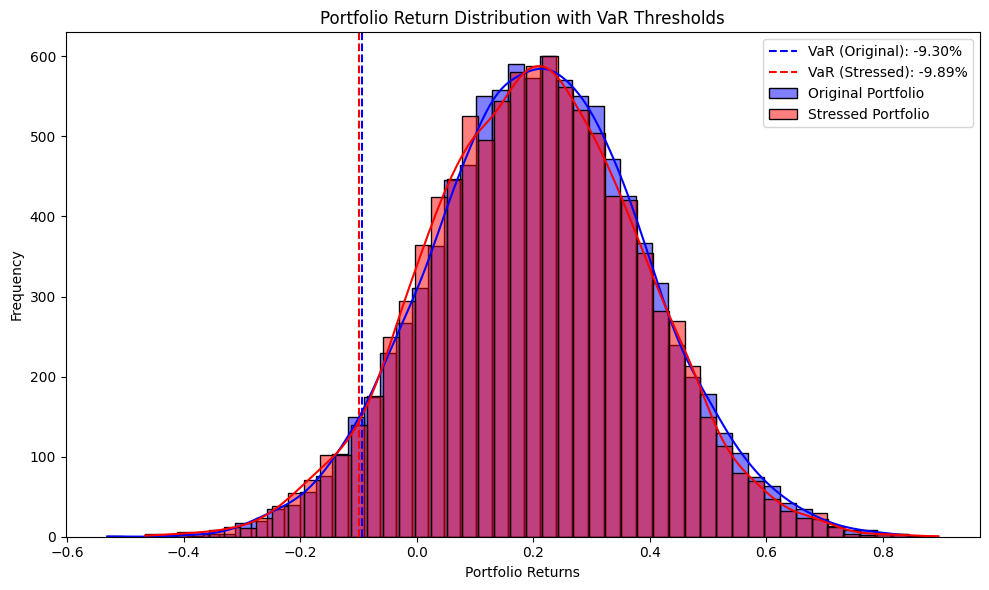

In [15]:
# Display results
print("\nRisk Metrics:")
print(f"Original Portfolio - VaR: ${original_var * initial_investment:,.2f}, CVaR: ${original_cvar * initial_investment:,.2f}")
print(f"Stressed Portfolio - VaR: ${stressed_var * initial_investment:,.2f}, CVaR: ${stressed_cvar * initial_investment:,.2f}")

# Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(original_portfolio_returns, bins=50, kde=True, label="Original Portfolio", color="blue")
sns.histplot(stressed_portfolio_returns, bins=50, kde=True, label="Stressed Portfolio", color="red")
plt.axvline(original_var, color="blue", linestyle="--", label=f"VaR (Original): {original_var:.2%}")
plt.axvline(stressed_var, color="red", linestyle="--", label=f"VaR (Stressed): {stressed_var:.2%}")
plt.title("Portfolio Return Distribution with VaR Thresholds")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
